A Hopfield Network is a simple mathematical model of the associative memory function of the brain whose long range mean field interactions are given by the Hamiltonian

$
H[S]=-\frac{1}{2}\sum_{i\neq j} J_{ij}S_i S_j.
$

Each neuron is a spin of two states connected to all other neurons with the coupling matrix $J_{ij}$ modeling the synaptic connections among different neurons. Memory is stored in the values taken by the synaptic connection between neurons. The synaptic weight matrix elements that be encoded of the necessary information using the Hebbian learning rule

$
J_{ij} = \frac{1}{N} \sum_{\mu}^{P} \xi_{i}^{\mu} \xi_{j}^{\mu},
$

where $\xi_{i}^{\mu}$ is the $i$-th spin of $\mu$-th patterns, with $i = 1, ..., N$ and $\mu = 1, ...,  P$. Hebbian learning accounts for full connection between all spins. It can be straightforwardly seen that the weight from neuron $i$ to $j$ is equal to that from $j$ to $i$, meaning the weight matrix of the Hopfield network must be fully symmetric, with no self-connection.

The spins evolve iteratively following a sign update rule that is applied every time a neuron's output is taken as input by all other neurons, making the Hopfield network a fully connected feedback neural network. In the following discussion spins are updated asynchronously, with each one single neuron at random updating its state at each iteration

$
S_i (t+1) = sgn(\sum_{j}^{N} J_{ij}S_i S_j).
$

Both equations are consistent with the convergence of the dynamics of the network to the stored pattern. It can indeed easily be proven that $\Delta H<0$, meaning that $H$ is a Lyapunov function of the system. It decreases along the dynamics and has minima at the stable fixed points, which correspond to the stored patterns. Spurious states are additional dynamic stable states that are not part of the stored memories and appear as local minima. They essentially represent well-defined mixtures of several stored patterns. For each fixed point there is a basin of attraction that is a set of initial conditions $\rho_i(t=0)$ such that the system converges to a stable fixed point. If the basin of attraction for a stored pattern $\xi^\mu$ is small then the network will perform worse to retrieve that pattern.

Ultimately, the goal is to build a Hopfield network model that, given an initial condition $\rho_{i}(t=0)$, will converge to the memory with the greatest overlap.

In the implementation that follows, for each stored pattern we will initialize the network with a noisy version of it, and test successful pattern retrieval.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import matplotlib.image as img
import seaborn as sns
from scipy.stats import norm

colormap = cm.tab10
np.random.seed(1234)

In [30]:
def generate_random_patterns(N:int, P:int):
    """ Generate homogeneous binary patterns (+1/-1) """
    xi = np.random.randint(0, 2, (P, N)) * 2 - 1 
    return xi

def weight_matrix(patterns: object):
    """ Compute Hopfield network weight matrix using Hebbian learning """
    num_patterns, N = patterns.shape
    J = np.tensordot(patterns, patterns, axes=(0, 0)) / N
    np.fill_diagonal(J, 0)
    return J

def noisify(pattern: object, noise: float):
    """ Add noise into patterns """
    noisy_pattern = pattern.copy()
    N = len(noisy_pattern)
    noises = np.random.choice(a=N, size=int(round(noise*N)), replace=False)
    noisy_pattern[noises] *= -1

    return noisy_pattern 

def energy_func(patterns: object, J: object):
    return -0.5 * patterns @ J @ patterns.T

def overlap(pattern_mu: object, pattern_nu: object):
    s    = pattern_nu
    xi    = pattern_mu
    return np.dot(s, xi) / s.size

def overlap_memory(pattern_mu: object, patterns_p: object):
    xi_P = patterns_p
    xi_mu = pattern_mu
    return np.dot(xi_P, xi_mu) / xi_mu.size

def retrieval_idx(retrieval, patterns):
    p_overlap = np.dot(patterns, retrieval) / N
    return np.argmax(abs(p_overlap))  

def network_flow(
    memory, J, noise, steps=100, EarlyStop=False, display=False,
    ):
    """ Computes the number of successfully retrieved patterns """
    #   patters:   set of stored patterns
    #   weights:   mean field couplings matrix
    #   noise:     fraction of bits to flip in the noisy pattern
    #   steps:     n iterations of asynchronous update rule
    #   display:   if True, shows energy of current state
    #   tolerance: number of iterations with no change in energy before stopping
    P, N = memory.shape
    
    # Vectorized noise addition
    noisy_patterns = memory * (2 * (np.random.rand(P, N) > noise) - 1)  
    overlap_init = np.array([np.dot(memory, noisy_patterns[mu]) / noisy_patterns[mu].size for mu in range(noisy_patterns.shape[0])])
    # Store attractors
    P_retrieved = np.zeros_like(noisy_patterns)
    suc_retrievals = np.zeros(P, dtype=int)
    spin_retrieval_acc = np.zeros(P)

    for p in range(P):
        P_retrieved[p] = update_pattern(noisy_patterns[p], J, steps, EarlyStop)
        
        p_overlap = np.dot(memory, P_retrieved[p]) / N
        
        idx = np.argmax(abs(p_overlap))  
        suc_retrievals[p] = (idx == p)
        
        spin_retrieval_acc[p] = p_overlap[p]

    if display:
        print(f"N: {N}, P: {P}, Patterns w/ {noise}% noise shape: {noisy_patterns.shape}, Fraction of retrieved patterns: {np.mean(spin_retrieval_acc)}")
    
    return P_retrieved, noisy_patterns, np.mean(suc_retrievals), np.mean(spin_retrieval_acc), overlap_init
    
def update_pattern(input_pattern, J, steps=100, EarlyStop=False):
    """Asynchronous update with batch processing"""
    
    pattern = input_pattern.copy()
    N = len(pattern)
    steps_tot = steps * N
    prev_energy = None
    
    for _ in range(steps_tot):
        i = np.random.randint(0, N)
        pattern[i] = np.sign(np.dot(J[i], pattern))

        if EarlyStop:
            current_energy = -0.5 * np.dot(pattern, J @ pattern.T)
            if prev_energy is not None and abs(current_energy - prev_energy) < 1e-5:
                break
            prev_energy = current_energy
    
    return pattern

def storage_capacity(N_list, P_range, noise=0.1):
    """ Analyze max storage capacity change for increasing network size """
    capacity = []
    for N in N_list:
        max_stored = 0
        patterns = generate_random_patterns(int(N), max(P_range))
        J = weight_matrix(patterns)
        for P in P_range:
            _, _, accuracy, _, _ = network_flow(patterns[:P], J, noise, steps=50, EarlyStop=True)
            if accuracy < 0.99:
                break
            max_stored = P  
        capacity.append(max_stored / N)
    return np.array(capacity)

def visualize_energy_distribution(stored_patterns, noisy_patterns, J):
    stored_energies = [energy_func(sp, J) for sp in stored_patterns]
    noisy_energies  = [energy_func(ic, J) for ic in noisy_patterns] 
    
    sns.kdeplot(stored_energies,   label="Memory (Stable)", color="blue", fill=True)
    sns.kdeplot(noisy_energies,    label="Noise (Initial Condition)", color="orange", fill=True)
    plt.xlabel("Energy")
    plt.ylabel("Density")
    plt.grid(True)
    plt.title("Energy Distribution of States (KDE))")
    plt.legend()
    plt.show()

def compute_crosstalk(N, P):
    crosstalk = []
    if P == 1:
        return np.array([0])
    for _ in range(num_trials):
        patterns = np.random.choice([-1, 1], size=(P, N))
        nu = 0
        other_patterns = np.delete(patterns, nu, axis=0)
        cross_term = (1 / N) * np.dot(other_patterns.T, other_patterns @ patterns[nu])
        crosstalk.append(cross_term)

    return np.array(crosstalk).flatten()

def visualize_patterns(patterns, title="Patterns"):
        fig, axes = plt.subplots(1, len(patterns), figsize=(12, 3))
        for i, pattern in enumerate(patterns):
            axes[i].imshow(pattern.reshape(int(np.sqrt(N)), int(np.sqrt(N))), cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f"Pattern {i+1}")
        plt.suptitle(title)
        plt.show()

In [3]:
def generate_my_patterns(N, P):
    my_p = np.array([
        [np.where(np.cos(x) > 0.1, 1, -1) for x in range(N)],
        [np.where(np.sin(x) > 0.85, 1, -1) for x in range(N)],
        [np.where(np.log(x) > 4, 1, -1) for x in range(1, N+1)]
    ])
    return np.concatenate((my_p, generate_random_patterns(N, P=P-3)), axis=0)

N, P, noise = 100, 6, 0.2
my_patterns = generate_my_patterns(N, P)
my_noisy_patterns = np.array([noisify(p, noise) for p in my_patterns])

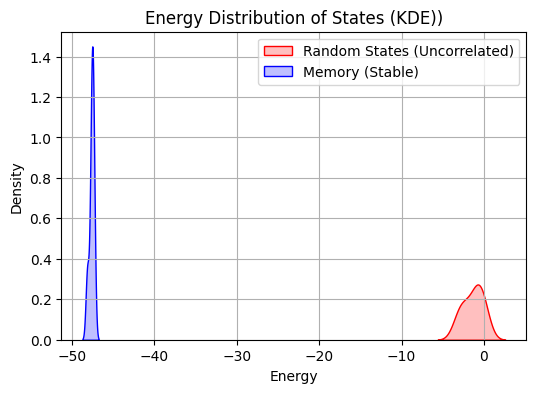

In [4]:
J = weight_matrix(my_patterns)
stored_energies = [energy_func(p, J) for p in my_patterns]
noisy_energies = [energy_func(p, J) for p in my_noisy_patterns]
random_states = generate_random_patterns(N, P)
random_energies = [energy_func(p, J) for p in random_states]

plt.figure(figsize=(6, 4))
sns.kdeplot(random_energies,   label="Random States (Uncorrelated)", color="red", fill=True)
visualize_energy_distribution(my_patterns, my_noisy_patterns, J)

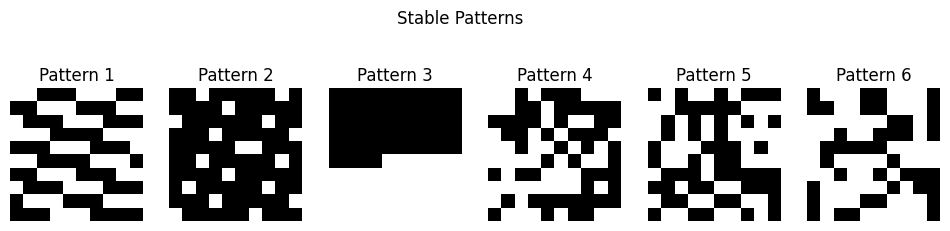

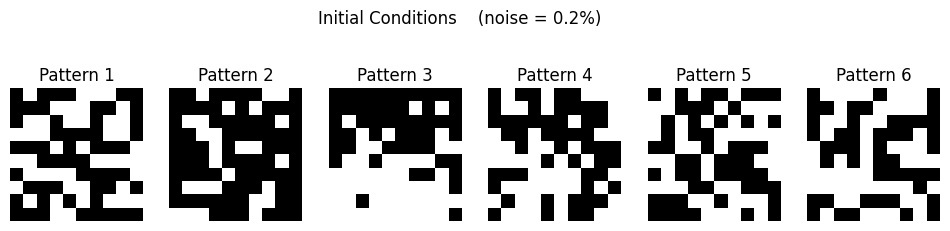

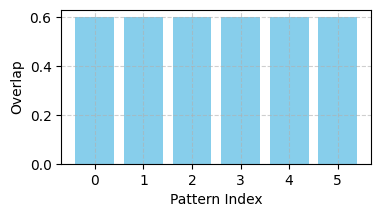

In [5]:
visualize_patterns(my_patterns, title="Stable Patterns")
visualize_patterns(my_noisy_patterns, title=f"Initial Conditions    (noise = {noise}%)")


my_overlap = [overlap(my_patterns[i], my_noisy_patterns[i]) for i in range(P)]

plt.figure(figsize=(4, 2))
plt.bar(range(P), my_overlap, color='skyblue')
plt.xlabel("Pattern Index")
plt.ylabel("Overlap")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

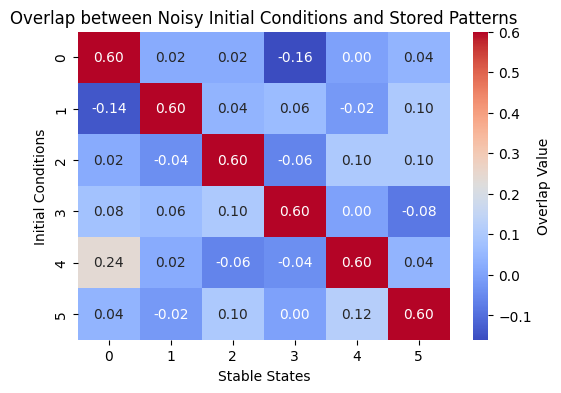

In [6]:
overlap_matrix = np.array([overlap_memory(my_noisy_patterns[i], my_patterns) for i in range(my_patterns.shape[0])])

plt.figure(figsize=(6, 4))
sns.heatmap(overlap_matrix, annot=True, cmap="coolwarm", cbar_kws={'label': 'Overlap Value'}, fmt=".2f")
plt.xlabel("Stable States")
plt.ylabel("Initial Conditions")
plt.title("Overlap between Noisy Initial Conditions and Stored Patterns")
plt.show()

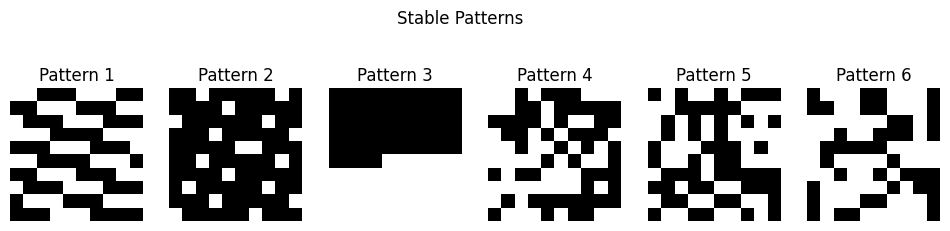

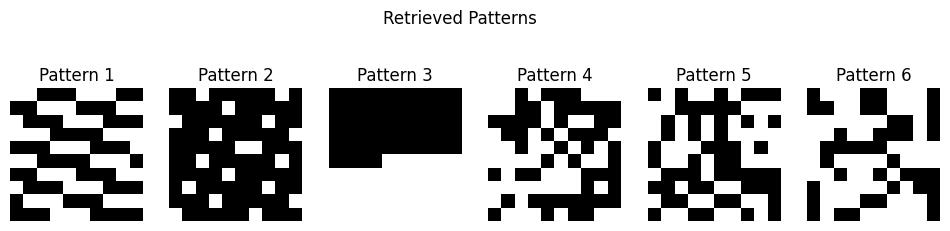

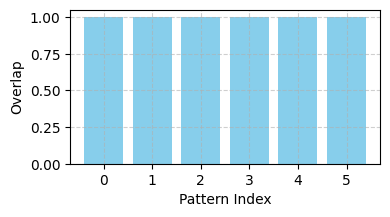

In [7]:
my_retrieved_patterns = np.array([update_pattern(p, J, steps=200) for p in my_noisy_patterns])

visualize_patterns(my_patterns, title="Stable Patterns")
visualize_patterns(my_retrieved_patterns, title="Retrieved Patterns")

my_r_overlap = [overlap(my_patterns[i], my_retrieved_patterns[i]) for i in range(P)]

plt.figure(figsize=(4, 2))
plt.bar(range(P), my_r_overlap, color='skyblue')
plt.xlabel("Pattern Index")
plt.ylabel("Overlap")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

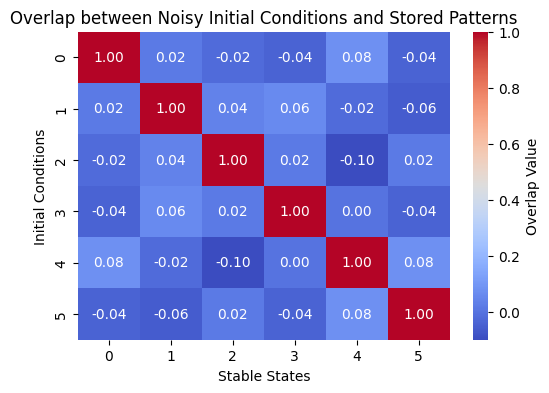

In [8]:
overlap_r_matrix = np.array([overlap_memory(my_retrieved_patterns[i], my_patterns) for i in range(my_patterns.shape[0])])

plt.figure(figsize=(6, 4))
sns.heatmap(overlap_r_matrix, annot=True, cmap="coolwarm", cbar_kws={'label': 'Overlap Value'}, fmt=".2f")
plt.xlabel("Stable States")
plt.ylabel("Initial Conditions")
plt.title("Overlap between Noisy Initial Conditions and Stored Patterns")
plt.show()

In [9]:
noises = np.linspace(0, 0.45, 10)
num_trials = 100

P_set_shape = (len(noises), my_patterns.shape[0], my_patterns.shape[1])
retrieval_set = np.zeros(P_set_shape)
overlap_init_set = np.zeros((len(noises), my_patterns.shape[0], my_patterns.shape[0]))
noisy_set = np.zeros(P_set_shape)
frac_suc_ret_set = np.zeros(len(noises))
spin_ret_acc_set = np.zeros(len(noises))

for i, noise in enumerate(noises):
    trial_retrievals = []
    trial_overlaps = []
    trial_noisy_patterns = []
    trial_frac_success = []
    trial_spin_acc = []

    for _ in range(num_trials):
        retrieved_P, noisy_P, frac_suc_ret, spin_ret_acc, overlap_init = network_flow(my_patterns, J, noise)

        trial_retrievals.append(retrieved_P)
        trial_noisy_patterns.append(noisy_P)
        trial_frac_success.append(frac_suc_ret)
        trial_spin_acc.append(spin_ret_acc)
        trial_overlaps.append(overlap_init)

    retrieval_set[i] = np.mean(trial_retrievals, axis=0)
    noisy_set[i] = np.mean(trial_noisy_patterns, axis=0)
    frac_suc_ret_set[i] = np.mean(trial_frac_success)
    spin_ret_acc_set[i] = np.mean(trial_spin_acc)
    overlap_init_set[i] = np.mean(trial_overlaps, axis=0)

mean_self_overlap = np.mean(np.diagonal(overlap_init_set, axis1=1, axis2=2), axis=1)

mean_sys_overlap = np.array([
        np.mean([
            np.sum(
                [abs(overlap_init_set[n, i, j])
                for j in range(overlap_init_set.shape[1]) 
                if j!=i]
                )
        for i in range(overlap_init_set.shape[1])])
        for n in range(overlap_init_set.shape[0])
    ])

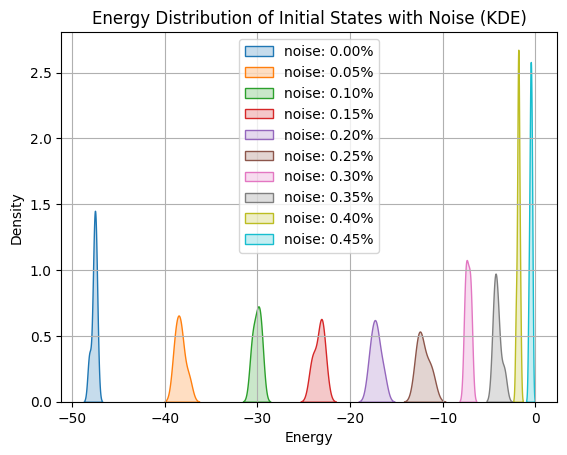

error:         	0.00	0.05	0.10	0.15	0.20	0.25	0.30	0.35	0.40	0.45
accuracy:	1.00	1.00	1.00	1.00	1.00	0.99	0.93	0.82	0.59	0.29


In [10]:
J = weight_matrix(my_patterns)
noisy_energies_set = np.array([[energy_func(p, J) for p in sp] for sp in noisy_set])
noisy_energies_set.shape

plt.figure()

for i, energies in enumerate(noisy_energies_set):
    sns.kdeplot(energies, label=f"noise: {noises[i]:.2f}%", fill=True)
    
plt.xlabel("Energy")
plt.ylabel("Density")
plt.title("Energy Distribution of Initial States with Noise (KDE)")
plt.grid(True)
plt.legend()
plt.show()

print(f"error:         \t{noises[0]:.2f}\t{noises[1]:.2f}\t{noises[2]:.2f}\t{noises[3]:.2f}\t{noises[4]:.2f}\t{noises[5]:.2f}\t{noises[6]:.2f}\t{noises[7]:.2f}\t{noises[8]:.2f}\t{noises[9]:.2f}")
print(f"accuracy:\t{spin_ret_acc_set[0]:.2f}\t{spin_ret_acc_set[1]:.2f}\t{spin_ret_acc_set[2]:.2f}\t{spin_ret_acc_set[3]:.2f}\t{spin_ret_acc_set[4]:.2f}\t{spin_ret_acc_set[5]:.2f}\t{spin_ret_acc_set[6]:.2f}\t{spin_ret_acc_set[7]:.2f}\t{spin_ret_acc_set[8]:.2f}\t{spin_ret_acc_set[9]:.2f}")

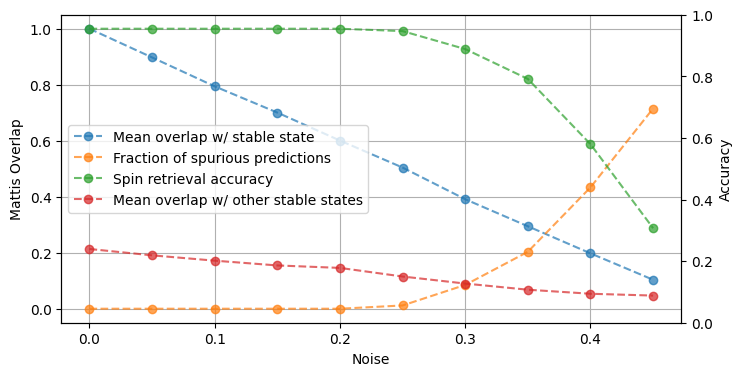

In [11]:
plt.figure(figsize=(8,4))
plt.plot(noises, mean_self_overlap,    marker="o", linestyle="--", alpha=0.7, label="Mean overlap w/ stable state")
plt.plot(noises, 1-frac_suc_ret_set,   marker="o", linestyle="--", alpha=0.7, label="Fraction of spurious predictions")
plt.plot(noises, spin_ret_acc_set,     marker="o", linestyle="--", alpha=0.7, label="Spin retrieval accuracy ")
plt.plot(noises, mean_sys_overlap,     marker="o", linestyle="--", alpha=0.7, label="Mean overlap w/ other stable states")
plt.xlabel("Noise")
plt.ylabel("Mattis Overlap")
plt.legend(loc="center left")
plt.grid(True)
ax2 = plt.gca().twinx()
ax2.set_ylabel("Accuracy")
plt.show()

Noise is added randomly flipping the value of a spin. As two opposite spin configurations are energetically equivalent. Beyond 50% noise the network will converge to the reverse states.

From the above graphs we see that noise not only raises the energetic configuration of the initial conditions, but it also reduces the overlap of the initial conditions with the stored patterns. In the above graph we indeed see that beyond a threshold (around $m=0.3$) the network becomes unstable, with retrieval of spurious states becoming dominant.

The overlap is an order parameter of the Hopfield model (effectively acting as the magnetization for an Ising model), meaning that beyond a critical value the system will undergo a phase transition. For a Hopfield Model the phase transition is from Ferromagnetic (FM) phase, with retrieval behavior dominated by the stable states, to Sping Glass (SG) phase, with the network mostly converging to the spurious mixtures of stable states.

In [18]:
N_values = [50, 100, 200]
alpha_values = np.linspace(0.01, 0.2, 15)
trials = 50

phase_transition_results = {}

for N in N_values:
    phase_diagram = []
    
    for alpha in alpha_values:
        P = int(alpha * N)
        patterns = generate_random_patterns(N, P)
        J = weight_matrix(patterns)

        retrieval_success = []
        for _ in range(trials):
            noisy_patterns = np.array([noisify(p, 0.1) for p in patterns])
            retrieved_patterns = np.array([update_pattern(p, J, steps=50) for p in noisy_patterns])
            retrievals = [np.array_equal(retrieved_patterns[i], patterns[i]) for i in range(P)]
            if len(retrievals) > 0: retrieval_mean = np.mean(retrievals)
            else: retrieval_mean = np.nan
            retrieval_success.append(retrieval_mean)

        if len(retrieval_success) > 0: mean_success = np.mean(retrieval_success)
        else: mean_success = np.nan
        
        phase_diagram.append(mean_success)
        
    phase_transition_results[N] = np.array(phase_diagram)

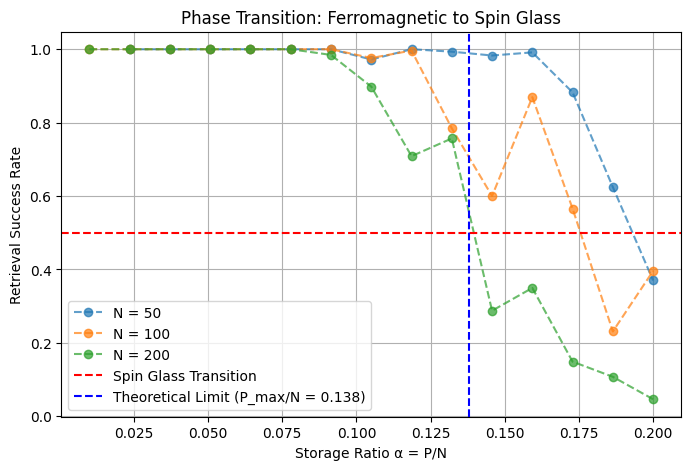

In [19]:
plt.figure(figsize=(8, 5))

for N, success_rates in phase_transition_results.items():
    plt.plot(alpha_values, success_rates, alpha=0.7, marker="o", linestyle="--", label=f"N = {N}")

plt.axhline(0.5, color="r", linestyle="--", label="Spin Glass Transition")
plt.xlabel("Storage Ratio α = P/N")
plt.ylabel("Retrieval Success Rate")
plt.axvline(x=0.138, color='b', linestyle="--", label="Theoretical Limit (P_max/N = 0.138)")
plt.title("Phase Transition: Ferromagnetic to Spin Glass")
plt.legend()
plt.grid()
plt.show()

Each stored pattern $\xi_i^\mu$ has two fixed points $\pm\xi_i^\mu$ which are "stable" or "attractors" under our deterministic update rule. At $t=0$ we "place" $i$-th spin of the initial condition in the network and compute the local magnetic field $h_i = \frac{1}{N} \sum_{j} J_{ij} p_j$. Say we pick a stored pattern $\xi^\nu$, we find that $h_i = \xi^\nu + C_{i}^{\nu}$, where $C_{i}^{\nu}$ is known as the "cross-talk" term. It contributes to the local field causing the appearance of additional dynamically stable states. The cross-talk term is proportional to the overlap of our initial condition and all other patterns, then the higher the density of memorized patterns in the network the more spurious states will appear.

In the following analysis we will estimate the basins of attractions of the network stable fixed points. We start with a Hopfield network storing $P$ random patterns $\xi_i^\mu$ with $N$ spins. Say the fixed points are given by the patterns $\xi_i^\mu$ and their opposite $-\xi_i^\mu$, any odd combination of fixed points has non zero overlap with its components giving new metastable states. We visualize the spurious states given by the mixture $\xi_i^{sp}=sign(\pm\xi_i^{\mu_1}\pm \xi_i^{\mu_2}\pm \xi_i^{\mu_3})$. We start with a network $N=100$, that stores $P=10$ random patterns and estimate the basin of attraction of a fixed point $\xi_i$.

We plot the fraction of correct retrievals as a function of the overlaps $m$ between initial conditions and fixed points. The basin of attraction here is defined by the value of $m$ such that retrieval goes below $50\%$.

In [31]:
def generate_spurious_states(patterns):
    P, N = patterns.shape
    spurious_states = []
    
    for _ in range(P):
        mu1, mu2, mu3 = np.random.choice(P, 3, replace=False)
        spurious_state = np.sign(patterns[mu1] + patterns[mu2] + patterns[mu3])
        spurious_states.append(spurious_state)
    
    return np.array(spurious_states)

N = 100
P = 10
noise = 0.1
stable_states   = generate_random_patterns(N, P)
ic_patterns     = noisify(stable_states, noise)
spurious_patterns = generate_spurious_states(stable_states)

J = weight_matrix(stable_states)
spurious_energies = [energy_func(p, J)  for p  in spurious_patterns]
stable_energies   = [energy_func(sp, J) for sp in stable_states]
ic_energies       = [energy_func(ic, J) for ic in ic_patterns]

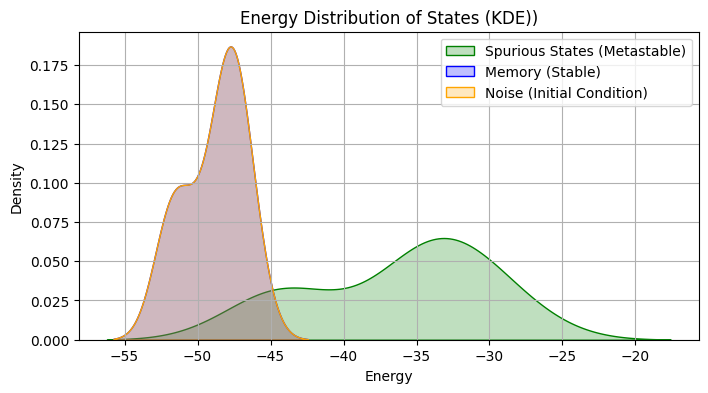

In [32]:
plt.figure(figsize=(8, 4))
sns.kdeplot(spurious_energies, label="Spurious States (Metastable)", color="green", fill=True)
sns.kdeplot(stable_energies,   label="Memory (Stable)",              color="blue", fill=True)
sns.kdeplot(ic_energies,       label="Noise (Initial Condition)",    color="orange", fill=True)

plt.xlabel("Energy")
plt.ylabel("Density")
plt.grid(True)
plt.title("Energy Distribution of States (KDE))")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
N = 100
P = 10
trials = 50
q_params = np.linspace(0, 0.5, 20)
patterns = generate_random_patterns(N, P)
J = weight_matrix(patterns)

retrieval_rates = []
overlaps = []

for q in q_params:
    success_count = 0
    total_count = P * trials
    overlap_values = []
    
    for mu in range(P):
        for _ in range(trials):
            noisy_pattern = noisify(patterns[mu], q)
            overlap_initial = np.dot(patterns[mu], noisy_pattern) / N
            overlap_values.append(overlap_initial)

            retrieved = update_pattern(noisy_pattern, J, steps=50)
            
            if np.array_equal(retrieved, patterns[mu]):
                success_count += 1
    
    retrieval_rates.append(success_count / total_count)
    overlaps.append(np.mean(overlap_values))

retrieval_rates = np.array(retrieval_rates)
overlaps = np.array(overlaps)

below_threshold = np.where(retrieval_rates < 0.5)[0]
m_critical = overlaps[below_threshold[0]]

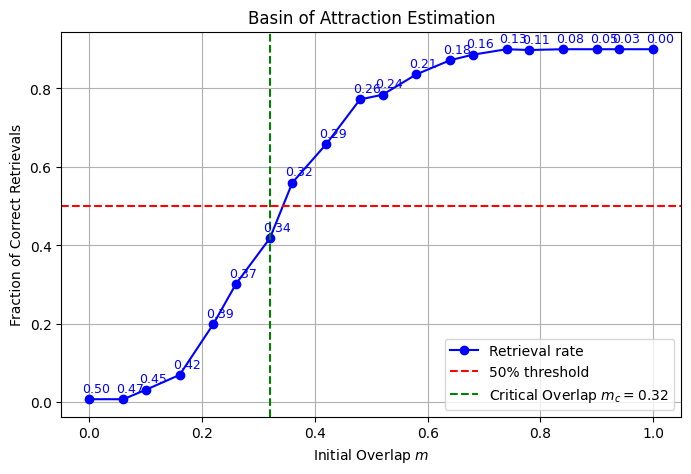

In [16]:
plt.figure(figsize=(8, 5))

plt.plot(overlaps, retrieval_rates, marker='o', linestyle='-', label="Retrieval rate", color="blue")
plt.axhline(y=0.5, color='r', linestyle='--', label="50% threshold")
plt.axvline(x=m_critical, color='g', linestyle='--', label=f"Critical Overlap $m_c={m_critical:.2f}$")
plt.xlabel("Initial Overlap $m$")
plt.ylabel("Fraction of Correct Retrievals")

for i, q in enumerate(q_params):
    plt.annotate(f"{q:.2f}", (overlaps[i], retrieval_rates[i]),
                textcoords="offset points", xytext=(5, 5), 
                ha='center', fontsize=9, color="blue")

plt.title("Basin of Attraction Estimation")
plt.legend()
plt.grid()
plt.show()

So far we have seen that a finite set of patterns $P<<N$ an initial condition with a limited error $q$ fed to the network converges to its stable state. Now we want to estimate the probability of flipping a spin in the wrong direction in a single step. This probability is related to the Storage Capacity of our network, that is the maximum number of patterns that can be stored are correctly retrieve $\alpha = \frac{P_{max}}{N}$. Say we fix an acceptable error value $q=0.01$ for retrieval, we can find the maximum number of patterns that saturates this error $p_{max}(\epsilon)$.

Each pattern is a random vector $\xi_i^\mu$ with values $\{\pm1\}$ with equal probability. For each iteration, if the cross-talk term $|C|<1$ spins will aline correctly with their stable states' field. 

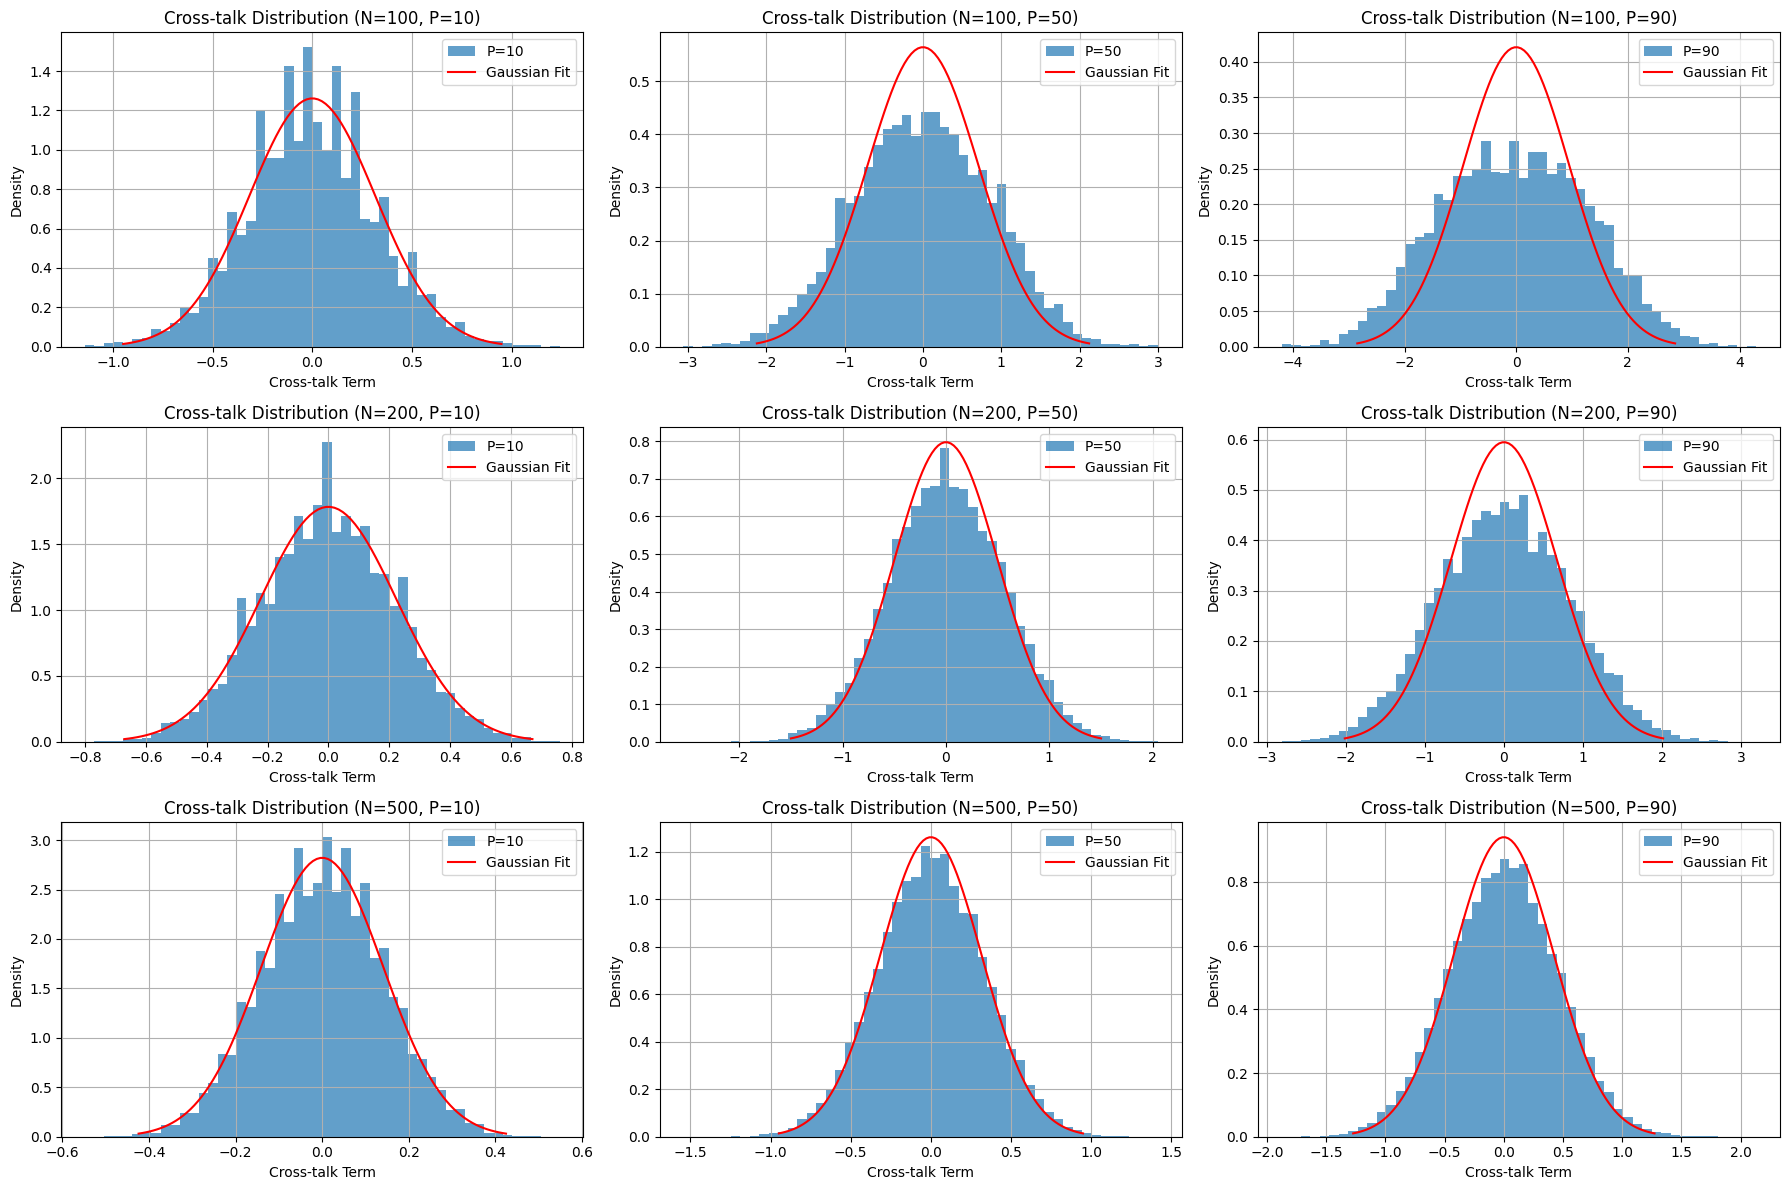

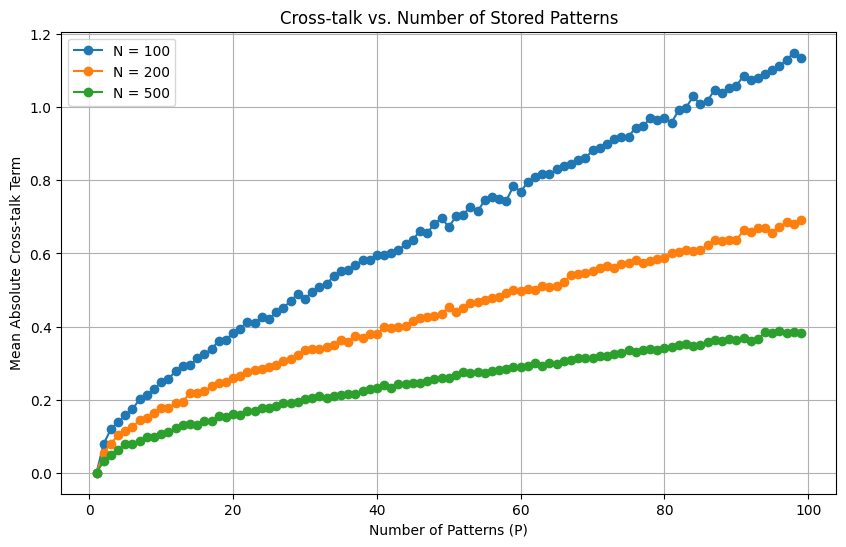

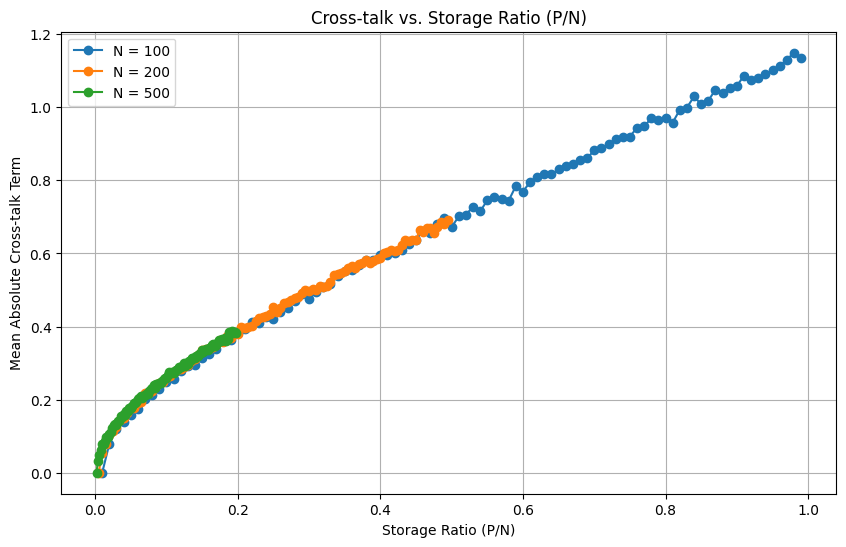

In [37]:
N_values = [100, 200, 500]
P_values = np.arange(1, 100, 1)
num_trials = 100 

crosstalk_distributions = {}

for N in N_values:
    crosstalk_distributions[N] = []
    for P in P_values:
        crosstalk = compute_crosstalk(N, P)
        crosstalk_distributions[N].append(crosstalk)

plt.figure(figsize=(18, 12))

for j, N in enumerate(N_values):
    for i, P in enumerate([10, 50, 90]):
        plt.subplot(len(N_values), 3, j*3 + i + 1)
        p = P_values[P_values == P][0]
        plt.hist(crosstalk_distributions[N][p], bins=50, density=True, alpha=0.7, label=f"P={P}")
        mu, sigma = 0, np.sqrt(P/N)
        x = np.linspace(-3*sigma, 3*sigma, 100)
        plt.plot(x, norm.pdf(x, mu, sigma), color='red', label="Gaussian Fit")
        plt.xlabel("Cross-talk Term")
        plt.ylabel("Density")
        plt.title(f"Cross-talk Distribution (N={N}, P={P})")
        plt.legend()
        plt.grid(True)

plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 6))

for N in N_values:
    mean_crosstalk = [np.mean(np.abs(crosstalk_distributions[N][i])) for i in range(len(P_values))]
    plt.plot(P_values, mean_crosstalk, marker='o', linestyle='-', label=f"N = {N}")

plt.xlabel("Number of Patterns (P)")
plt.ylabel("Mean Absolute Cross-talk Term")
plt.title("Cross-talk vs. Number of Stored Patterns")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))

for N in N_values:
    mean_crosstalk = [np.mean(np.abs(crosstalk_distributions[N][i])) for i in range(len(P_values))]
    plt.plot(np.array(P_values) / N, mean_crosstalk, marker='o', linestyle='-', label=f"N = {N}")

plt.xlabel("Storage Ratio (P/N)")
plt.ylabel("Mean Absolute Cross-talk Term")
plt.title("Cross-talk vs. Storage Ratio (P/N)")
plt.legend()
plt.grid(True)
plt.show()

As a function of increasing $p$, we can find the largest $p_{max}$ beyond which a network storing $p$ patterns fails to successfully retrieve all of them: the capacity is then defined as $\alpha_c(N)=p_{max}/N$. In the following, we will calculate the capacity $\alpha_c(N)$ as a function of increasing $N=10:1000$ and check that it converges to the theoretical value at large $N$, $\alpha_c=0.138$.

In [21]:
N_list = list(range(10, 500, 10))
trials = 20

capacities = []
for _ in range(trials):
    capacity = storage_capacity(N_list, P_range=range(1, 75, 1))
    capacities.append(capacity)
    
mean_capacity = np.mean(capacities, axis=0)
std_capacity  = np.std(capacities, axis=0)

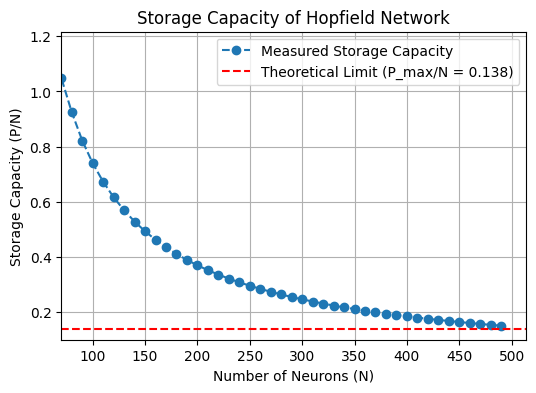

Mean standard deviation: 0.024868292649875095


In [22]:
plt.figure(figsize=(6, 4))
plt.plot(N_list, mean_capacity, marker="o", linestyle="--", label="Measured Storage Capacity")
#plt.errorbar(N_list, mean_capacity, yerr=std_capacity, alpha=0.5, label="Measured Storage Capacity", capsize=3)
plt.axhline(y=0.138, color='r', linestyle="--", label="Theoretical Limit (P_max/N = 0.138)")
plt.xlabel("Number of Neurons (N)")
plt.ylabel("Storage Capacity (P/N)")
plt.xlim((70))
plt.legend()
plt.grid()
plt.title("Storage Capacity of Hopfield Network")
plt.show()
print("Mean standard deviation:", np.mean(std_capacity))